In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load dataset
dataset = pd.read_csv("kidney_disease.csv")

# Rename columns properly
dataset.columns = [
    'id','age','blood_pressure','specific_gravity','albumin','sugar',
    'red_blood_cells','pus_cell','pus_cell_clumps','bacteria',
    'blood_glucose_random','blood_urea','serum_creatinine','sodium',
    'potassium','haemoglobin','packed_cell_volume','white_blood_cell_count',
    'red_blood_cell_count','hypertension','diabetes_mellitus',
    'coronary_artery_disease','appetite','peda_edema','aanemia','classification'
]

# Select numerical columns of interest
num_cols = ['age','blood_pressure','blood_glucose_random','blood_urea',
            'serum_creatinine','sodium','potassium','haemoglobin']
df = dataset[num_cols].replace("?", pd.NA)

# Convert to numeric
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Impute missing values with median
imp = SimpleImputer(strategy="median")
df_imputed = pd.DataFrame(imp.fit_transform(df), columns=df.columns, index=df.index)
df_imputed

,age,blood_pressure,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin
0,48.0,80.0,121.0,36.0,1.2,138.0,4.4,15.4
1,7.0,50.0,121.0,18.0,0.8,138.0,4.4,11.3
2,62.0,80.0,423.0,53.0,1.8,138.0,4.4,9.6
3,48.0,70.0,117.0,56.0,3.8,111.0,2.5,11.2
4,51.0,80.0,106.0,26.0,1.4,138.0,4.4,11.6
...,...,...,...,...,...,...,...,...
395,55.0,80.0,140.0,49.0,0.5,150.0,4.9,15.7
396,42.0,70.0,75.0,31.0,1.2,141.0,3.5,16.5
397,12.0,80.0,100.0,26.0,0.6,137.0,4.4,15.8
398,17.0,60.0,114.0,50.0,1.0,135.0,4.9,14.2


In [3]:
univariate_stats = {}
for column in df_imputed:
    s = df_imputed[column]
    q1, q2, q3 = s.quantile([0.25,0.5,0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    univariate_stats[column] = {
        "Mean": round(s.mean(),2),
        "Median": round(s.median(),2),
        "IQR": round(iqr,2),
        "Min": s.min(),
        "Max": s.max(),
        "Skewness": round(s.skew(),2),
        "Kurtosis": round(s.kurtosis(),2),
        "Lower_Fence": round(lower,2),
        "Upper_Fence": round(upper,2)
    }

univariate_df = pd.DataFrame(univariate_stats).T
print(univariate_df)


                        Mean  Median    IQR   Min    Max  Skewness  Kurtosis  \
age                    51.56   55.00  22.00   2.0   90.0     -0.69      0.14   
blood_pressure         76.58   80.00  10.00  50.0  180.0      1.60      8.90   
blood_glucose_random  145.06  121.00  49.00  22.0  490.0      2.20      5.25   
blood_urea             56.69   42.00  34.75   1.5  391.0      2.72     10.00   
serum_creatinine        3.00    1.30   1.83   0.4   76.0      7.67     82.63   
sodium                137.63  138.00   6.00   4.5  163.0     -7.93    110.02   
potassium               4.58    4.40   0.80   2.5   47.0     13.13    183.42   
haemoglobin            12.54   12.65   3.75   3.1   17.8     -0.38     -0.08   

                      Lower_Fence  Upper_Fence  
age                          9.00        97.00  
blood_pressure              55.00        95.00  
blood_glucose_random        27.50       223.50  
blood_urea                 -25.12       113.88  
serum_creatinine            -1.84 

In [5]:
df_winsorized = df_imputed.copy()
for col in univariate_df.index:
    lower = univariate_df.loc[col,"Lower_Fence"]
    upper = univariate_df.loc[col,"Upper_Fence"]
    df_winsorized[col] = df_winsorized[col].clip(lower, upper)
df_winsorized

,age,blood_pressure,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin
0,48.0,80.0,121.0,36.0,1.2,138.0,4.4,15.4
1,9.0,55.0,121.0,18.0,0.8,138.0,4.4,11.3
2,62.0,80.0,223.5,53.0,1.8,138.0,4.4,9.6
3,48.0,70.0,117.0,56.0,3.8,126.0,2.8,11.2
4,51.0,80.0,106.0,26.0,1.4,138.0,4.4,11.6
...,...,...,...,...,...,...,...,...
395,55.0,80.0,140.0,49.0,0.5,150.0,4.9,15.7
396,42.0,70.0,75.0,31.0,1.2,141.0,3.5,16.5
397,12.0,80.0,100.0,26.0,0.6,137.0,4.4,15.8
398,17.0,60.0,114.0,50.0,1.0,135.0,4.9,14.2


In [6]:
df_winsorized.isnull().sum()

age                     0
blood_pressure          0
blood_glucose_random    0
blood_urea              0
serum_creatinine        0
sodium                  0
potassium               0
haemoglobin             0
dtype: int64

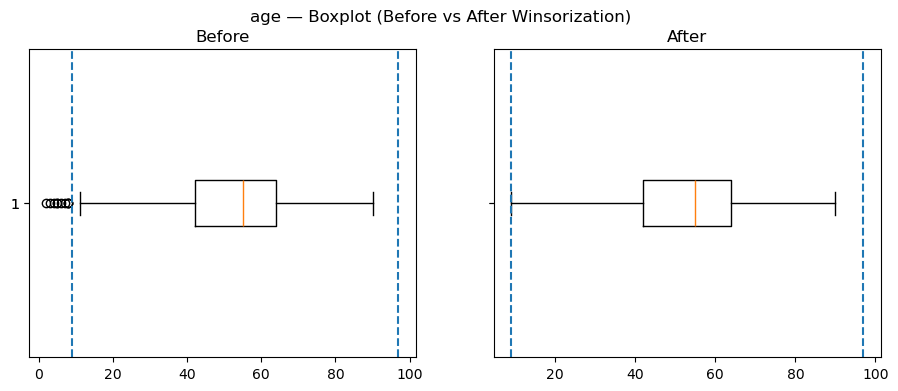

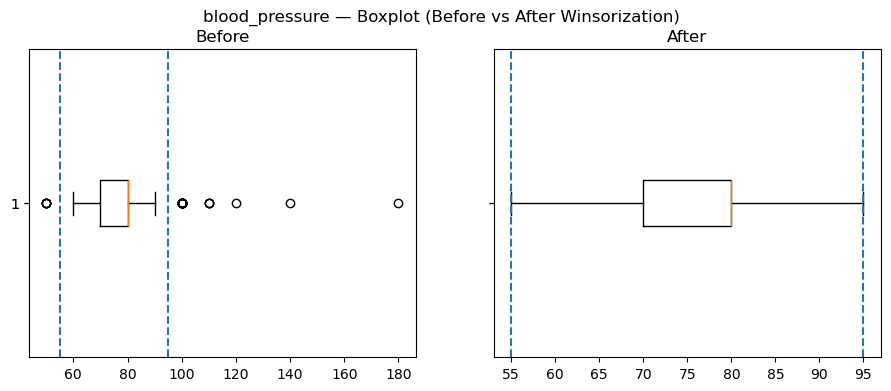

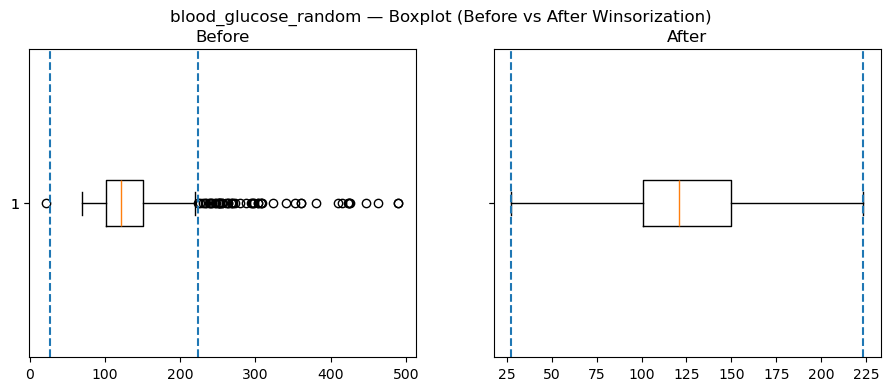

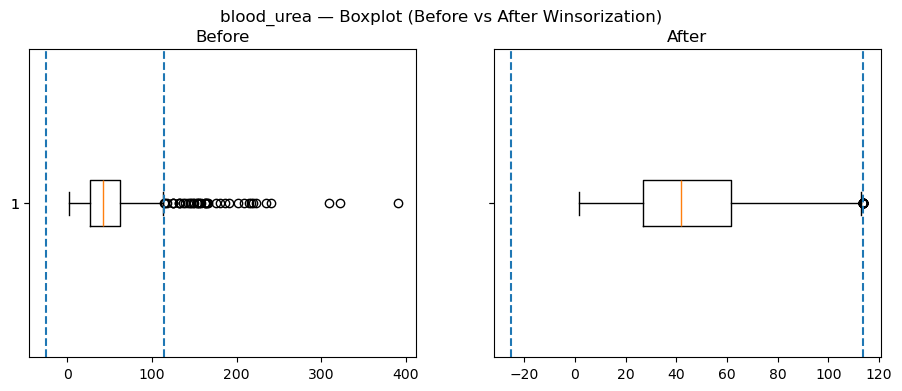

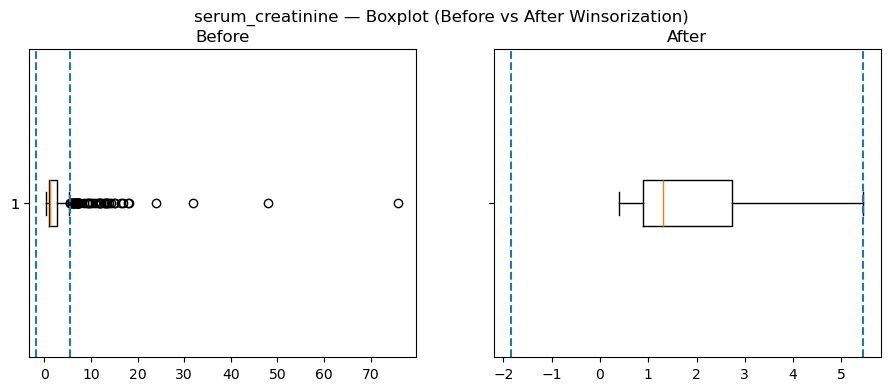

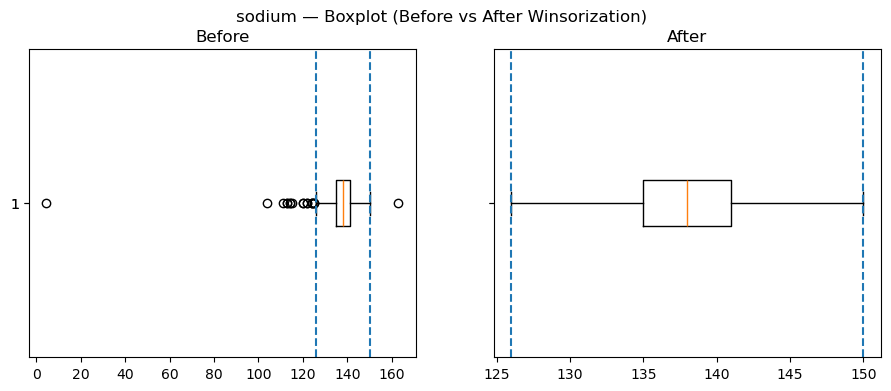

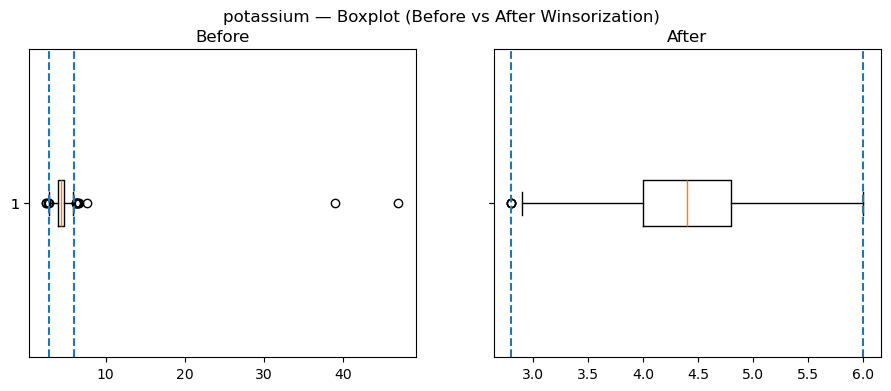

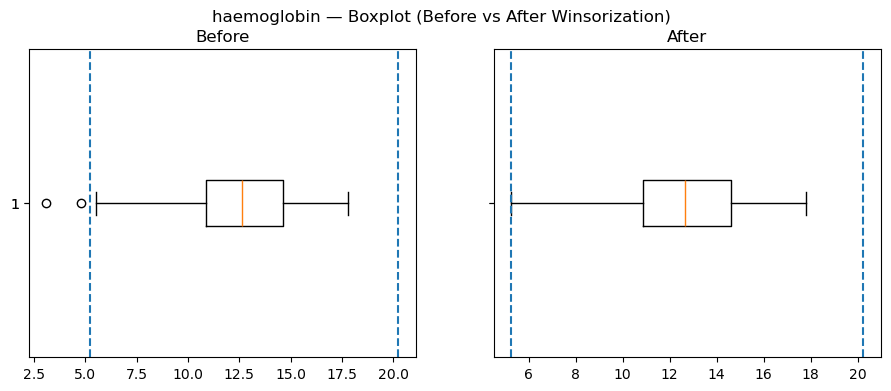

In [7]:
def boxplots_before_after(df_before, df_after, fences, cols=None):
    if cols is None: cols = list(fences.index)
    for col in cols:
        lb, ub = fences.loc[col,"Lower_Fence"], fences.loc[col,"Upper_Fence"]
        fig, axes = plt.subplots(1,2, figsize=(11,4), sharey=True)
        fig.suptitle(f"{col} — Boxplot (Before vs After Winsorization)", fontsize=12)

        axes[0].boxplot(df_before[col].dropna(), vert=False)
        axes[0].axvline(lb, linestyle="--"); axes[0].axvline(ub, linestyle="--")
        axes[0].set_title("Before")

        axes[1].boxplot(df_after[col].dropna(), vert=False)
        axes[1].axvline(lb, linestyle="--"); axes[1].axvline(ub, linestyle="--")
        axes[1].set_title("After")
        plt.show()

boxplots_before_after(df_imputed, df_winsorized, univariate_df)


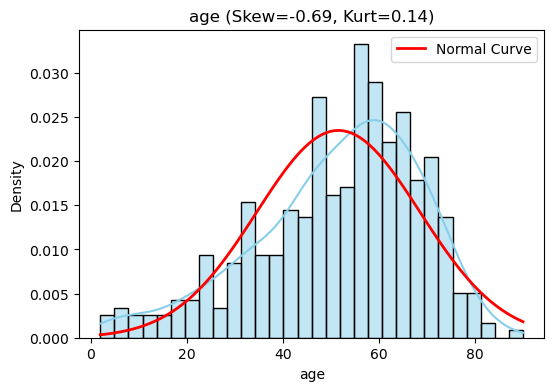

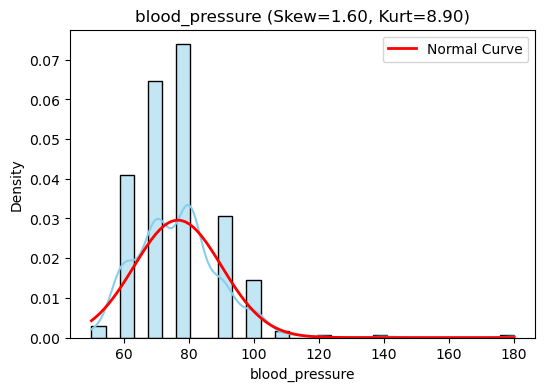

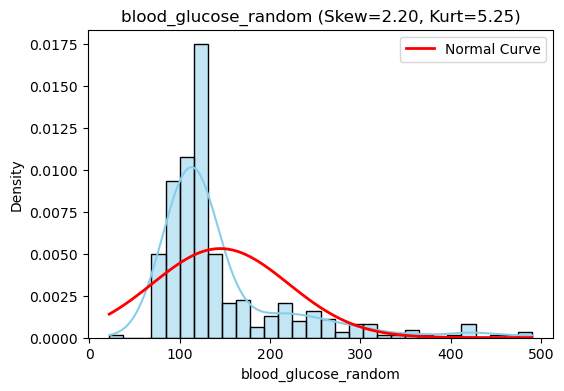

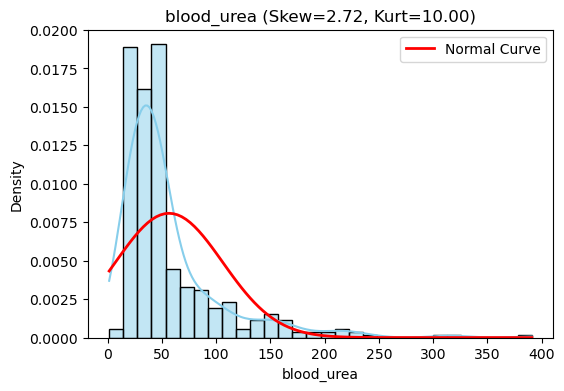

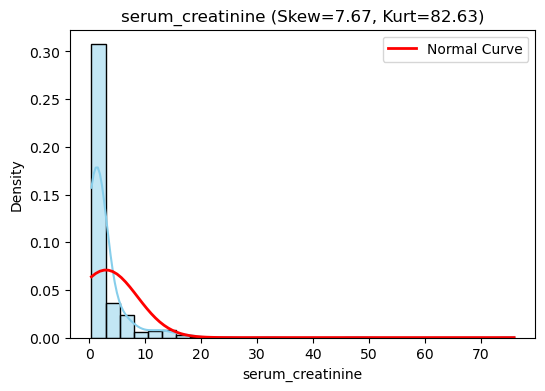

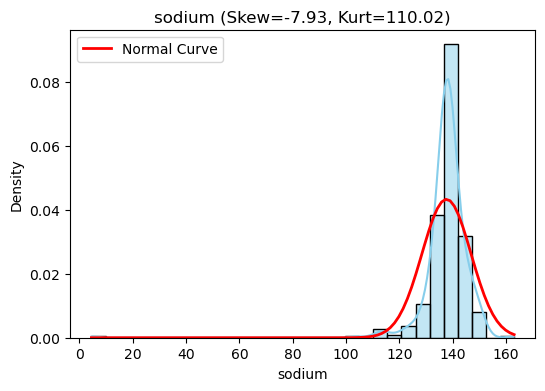

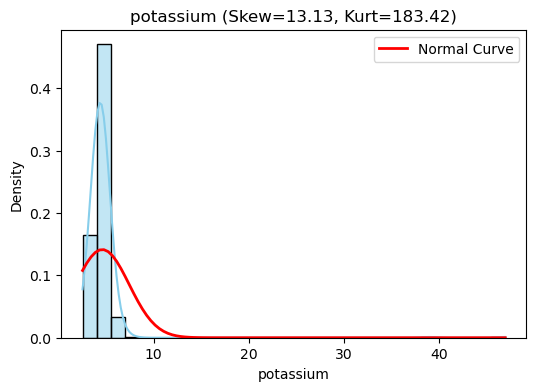

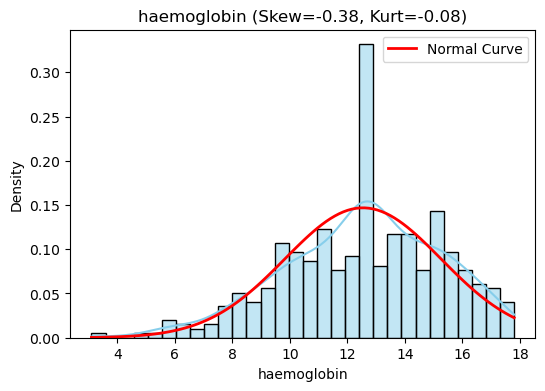

In [8]:
for col in df_imputed.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df_imputed[col], kde=True, stat="density", bins=30, color="skyblue")

    mu, sigma = df_imputed[col].mean(), df_imputed[col].std()
    x = np.linspace(df_imputed[col].min(), df_imputed[col].max(), 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r', linewidth=2, label="Normal Curve")

    plt.title(f"{col} (Skew={df_imputed[col].skew():.2f}, Kurt={df_imputed[col].kurtosis():.2f})")
    plt.legend()
    plt.show()


In [9]:
cat_cols = ['red_blood_cells','pus_cell','pus_cell_clumps','bacteria',
            'hypertension','diabetes_mellitus','coronary_artery_disease',
            'appetite','peda_edema','aanemia','classification']

def categorical_summary(df, column):
    freq = df[column].value_counts(dropna=False)
    rel_freq = freq / len(df) * 100
    cum_rel = rel_freq.cumsum()
    return pd.DataFrame({"Frequency": freq, "Relative %": rel_freq.round(2), "Cumulative %": cum_rel.round(2)})

for col in cat_cols:
    print(f"\n=== {col} ===")
    print(categorical_summary(dataset, col))



=== red_blood_cells ===
                 Frequency  Relative %  Cumulative %
red_blood_cells                                     
normal                 201       50.25         50.25
NaN                    152       38.00         88.25
abnormal                47       11.75        100.00

=== pus_cell ===
          Frequency  Relative %  Cumulative %
pus_cell                                     
normal          259       64.75         64.75
abnormal         76       19.00         83.75
NaN              65       16.25        100.00

=== pus_cell_clumps ===
                 Frequency  Relative %  Cumulative %
pus_cell_clumps                                     
notpresent             354        88.5          88.5
present                 42        10.5          99.0
NaN                      4         1.0         100.0

=== bacteria ===
            Frequency  Relative %  Cumulative %
bacteria                                       
notpresent        374        93.5          93.5
present   

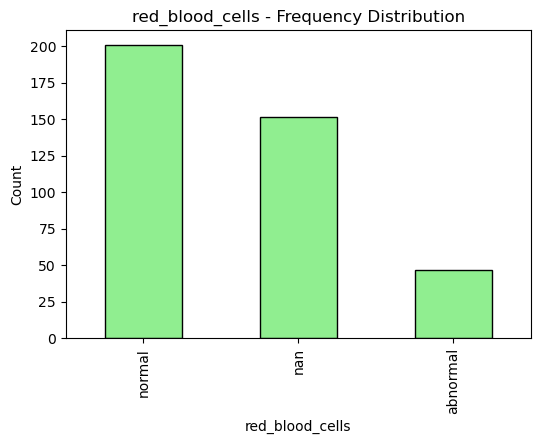

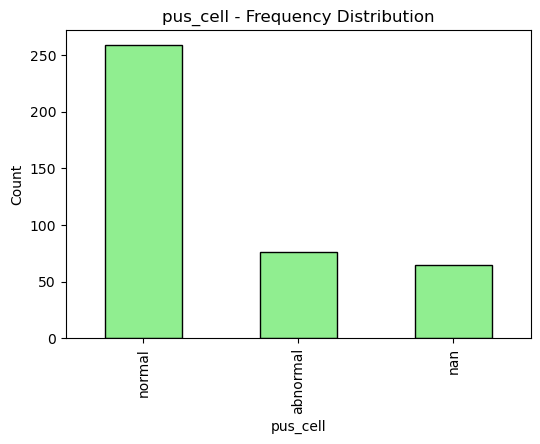

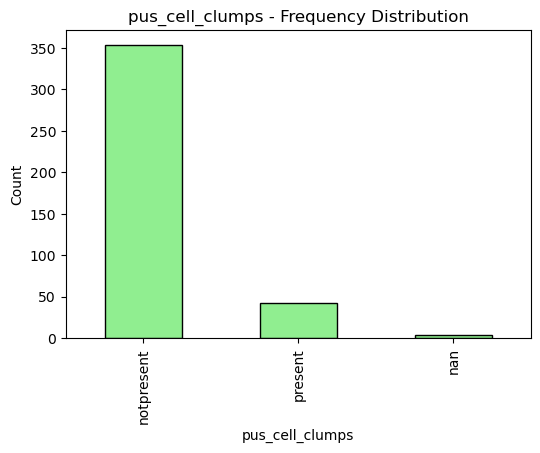

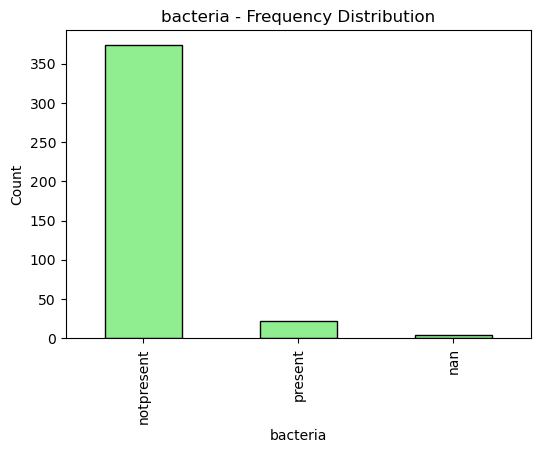

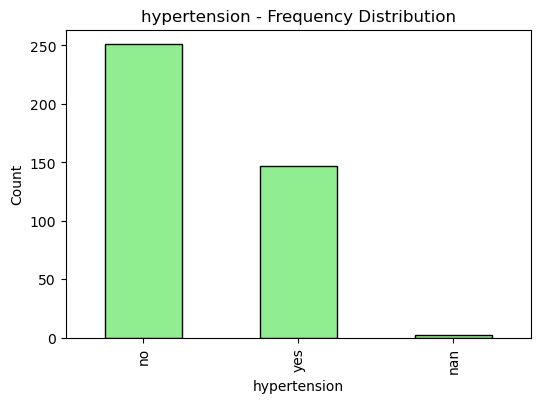

C:\Users\Nishok\miniconda3\envs\ml_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


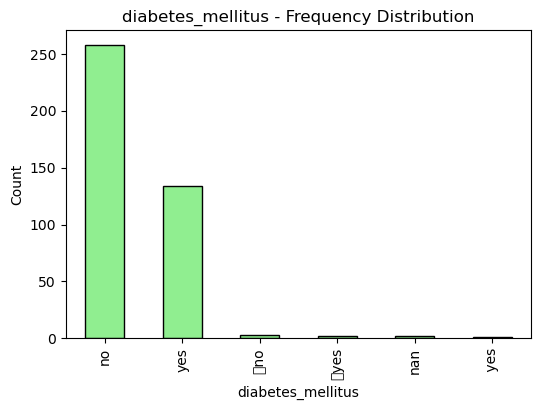

C:\Users\Nishok\miniconda3\envs\ml_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


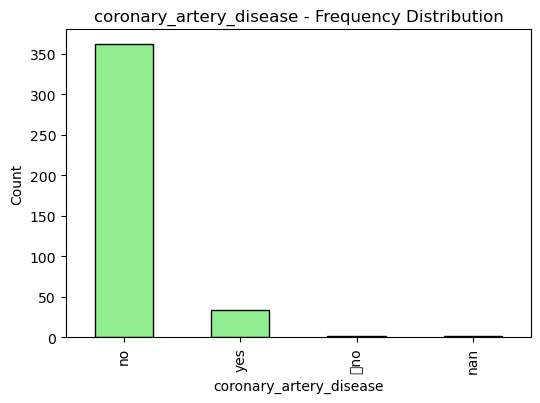

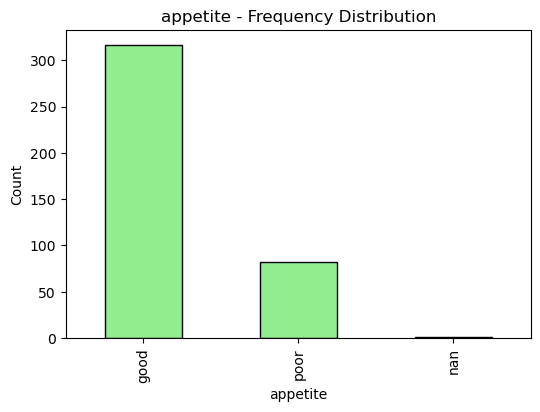

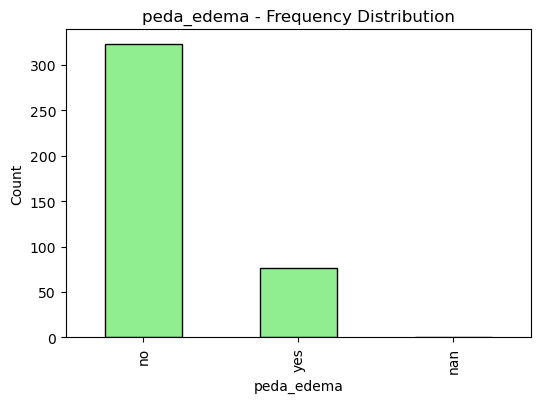

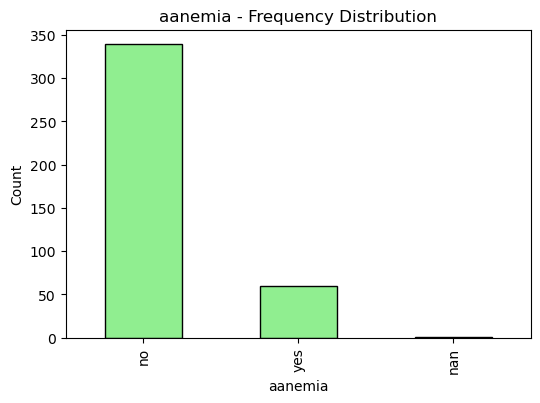

C:\Users\Nishok\miniconda3\envs\ml_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


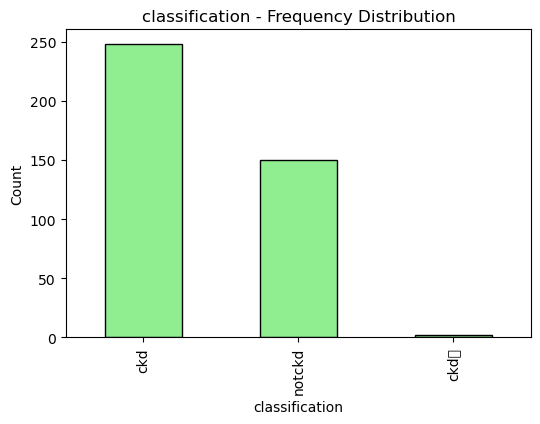

In [10]:
for col in cat_cols:
    dataset[col].value_counts(dropna=False).plot(kind='bar', figsize=(6,4), color="lightgreen", edgecolor="black")
    plt.title(f"{col} - Frequency Distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
